In [2]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from feature_engine import encoding, creation, transformation, outliers
from sklearn import base, pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

import xgboost as xgb

import yellowbrick.model_selection as ms

from joblib import load, dump

from IPython.display import JSON
import warnings
warnings.filterwarnings('ignore')

# adjust the style to emulate ggplot
plt.style.use('ggplot')

In [3]:
bicing = pd.read_parquet(r'..\data\processed\bicing_full.parquet').set_index('year').drop(index=[2023]).reset_index()

In [4]:
# met = pd.read_csv(r'..\src\pipeline\artifacts\metadata_sample_submission.csv', index_col='index')
# met_stations = met['station_id'].unique()
# bicing = bicing[bicing['station_id'].isin(met_stations)]

In [4]:
bicing

,year,station_id,month,day,hour,ctx_1,ctx_2,ctx_3,ctx_4,post_code,...,min_temp,avg_rel_humidity,acum_precipitation,avg_atm_pressure,global_solar_rad,avg_wind_speed,avg_wind_direction,max_wind_speed,max_streak_wind_direction,percentage_docks_available
0,2019,1,3,28,21,0.150000,0.383333,0.416667,0.466667,8013,...,9.225,51.25,0.0,1006.599976,22.100000,2.166667,131.666672,7.500000,119.000000,0.033333
1,2019,1,3,28,22,0.033333,0.150000,0.383333,0.416667,8013,...,9.225,51.25,0.0,1006.599976,22.100000,2.166667,131.666672,7.500000,119.000000,0.066667
2,2019,1,3,28,23,0.066667,0.033333,0.150000,0.383333,8013,...,9.225,51.25,0.0,1006.599976,22.100000,2.166667,131.666672,7.500000,119.000000,0.033333
3,2019,1,3,29,0,0.033333,0.066667,0.033333,0.150000,8013,...,8.600,57.75,0.0,1006.400024,22.299999,2.533333,73.000000,7.266667,164.333328,0.034483
4,2019,1,3,29,3,0.034483,0.033333,0.066667,0.033333,8013,...,8.600,57.75,0.0,1006.400024,22.299999,2.533333,73.000000,7.266667,164.333328,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292864,2022,519,12,31,19,0.895833,0.916667,0.875000,0.958333,8032,...,12.175,59.50,0.0,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344,0.750000
14292865,2022,519,12,31,20,0.750000,0.895833,0.916667,0.875000,8032,...,12.175,59.50,0.0,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344,0.666667
14292866,2022,519,12,31,21,0.666667,0.750000,0.895833,0.916667,8032,...,12.175,59.50,0.0,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344,0.583333
14292867,2022,519,12,31,22,0.583333,0.666667,0.750000,0.895833,8032,...,12.175,59.50,0.0,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344,0.583333


In [5]:
bicing.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14292869 entries, 0 to 14292868
Data columns (total 30 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   year                        uint16  
 1   station_id                  uint16  
 2   month                       uint8   
 3   day                         uint8   
 4   hour                        uint8   
 5   ctx_1                       float32 
 6   ctx_2                       float32 
 7   ctx_3                       float32 
 8   ctx_4                       float32 
 9   post_code                   int64   
 10  lat                         float32 
 11  lon                         float32 
 12  altitude                    uint16  
 13  capacity                    uint8   
 14  is_holiday                  bool    
 15  weekday                     uint8   
 16  weekend                     bool    
 17  season                      category
 18  avg_temp                    float32 
 19


| Variable           | Type        | Transformation strategy                                                                                  |
|--------------------|-------------|----------------------------------------------------------------------------------------------------------|
| station_id         | Categorical | enable_categorical if possible (e.g. XGBoost). On the contrary, mean target encoding                     |
| month              | Cyclic      | Generate two new features instead: month_sin, month_cos. Drop <code>month</code> column at the end       |
| day                | Cyclic      | Generate two new features instead: day_sin, day_cos. Drop <code>day</code> column at the end             |
| hour               | Cyclic      | Generate two new features instead: hour_sin, hour_cos. Drop <code>hour</code> column at the end          |
| weekday            | Cyclic      | Generate two new features instead: weekday_sin, weekday_cos. Drop <code>weekday</code> column at the end |
| weekend            | Categorical | It does not require transformation (boolean)                                                             |
| season             | Categorical | OneHotEncoding (4 unique values) with drop_last=True                                                     |
| is_holiday         | Categorical | It does not require transformation (boolean)                                                             |
| ctx_1              | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| ctx_2              | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| ctx_3              | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| ctx_4              | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| altitude           | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| avg_temp           | Numeric     | Scaling in case of non-tree based models (StandardScaler(MinMaxScaler)                                   |
| avg_rel_humidity   | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| acum_precipitation | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| global_solar_rad   | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |
| avg_wind_speed     | Numeric     | Scaling in case of non-tree based models (StandardScaler/MinMaxScaler)                                   |

In [6]:
def tweak_bicing(df_: pd.DataFrame) -> pd.DataFrame:

    return (df_
            .astype({'station_id': 'category'})  # to be treated as categorical variable by algorithms like XGBoost
            .drop(columns=['post_code', 'lat', 'lon', 'capacity', 'max_temp', 'min_temp', 'avg_atm_pressure', 'avg_wind_direction', 
                           'max_wind_speed', 'max_streak_wind_direction'])
            )

In [7]:
tweak_bicing(bicing)

,year,station_id,month,day,hour,ctx_1,ctx_2,ctx_3,ctx_4,altitude,is_holiday,weekday,weekend,season,avg_temp,avg_rel_humidity,acum_precipitation,global_solar_rad,avg_wind_speed,percentage_docks_available
0,2019,1,3,28,21,0.150000,0.383333,0.416667,0.466667,16,False,4,False,spring,13.100000,51.25,0.0,22.100000,2.166667,0.033333
1,2019,1,3,28,22,0.033333,0.150000,0.383333,0.416667,16,False,4,False,spring,13.100000,51.25,0.0,22.100000,2.166667,0.066667
2,2019,1,3,28,23,0.066667,0.033333,0.150000,0.383333,16,False,4,False,spring,13.100000,51.25,0.0,22.100000,2.166667,0.033333
3,2019,1,3,29,0,0.033333,0.066667,0.033333,0.150000,16,False,5,False,spring,12.725000,57.75,0.0,22.299999,2.533333,0.034483
4,2019,1,3,29,3,0.034483,0.033333,0.066667,0.033333,16,False,5,False,spring,12.725000,57.75,0.0,22.299999,2.533333,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14292864,2022,519,12,31,19,0.895833,0.916667,0.875000,0.958333,110,False,6,True,winter,16.299999,59.50,0.0,8.600000,2.766667,0.750000
14292865,2022,519,12,31,20,0.750000,0.895833,0.916667,0.875000,110,False,6,True,winter,16.299999,59.50,0.0,8.600000,2.766667,0.666667
14292866,2022,519,12,31,21,0.666667,0.750000,0.895833,0.916667,110,False,6,True,winter,16.299999,59.50,0.0,8.600000,2.766667,0.583333
14292867,2022,519,12,31,22,0.583333,0.666667,0.750000,0.895833,110,False,6,True,winter,16.299999,59.50,0.0,8.600000,2.766667,0.583333


In [8]:
class TweakBicingTransformer(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, ycol=None):
        self.ycol = ycol
        
    def transform(self, X):
        return tweak_bicing(X)
    
    def fit(self, X, y=None):
        return self

In [89]:
bicing_pl = pipeline.Pipeline(
    [
     ('tweak', TweakBicingTransformer()),
     ('cat_oneHot', encoding.OneHotEncoder(variables=['season'], drop_last=True)),
     ('log1p', transformation.LogCpTransformer(variables=['altitude', 'acum_precipitation', 'avg_wind_speed'], base='10')),
     ('outliers', outliers.Winsorizer(tail='both')),
     ('cyclic', creation.CyclicalFeatures(variables=['day', 'month', 'hour', 'weekday'], drop_original=True))   
    ]
)

In [82]:
bicing_pl

Pipeline(steps=[('tweak', TweakBicingTransformer()),
                ('cat_oneHot',
                 OneHotEncoder(drop_last=True, variables=['season'])),
                ('log1p',
                 LogCpTransformer(base='10',
                                  variables=['altitude', 'acum_precipitation',
                                             'avg_wind_speed'])),
                ('outliers', Winsorizer(tail='both')),
                ('cyclic',
                 CyclicalFeatures(drop_original=True,
                                  variables=['day', 'month', 'hour',
                                             'weekday']))])

In [90]:
def get_rawX_y(df, y_col):
    raw = (df
           .set_index('year')
           .drop(index=[2019, 2020])
           .reset_index()
          )
    # lower_limit, upper_limit = np.percentile(raw[y_col], [1, 99])
    # raw = raw.query('percentage_docks_available > @lower_limit and percentage_docks_available < @upper_limit')
    
    return raw.drop(columns=['year', y_col]), raw[y_col]

bicing_X, bicing_y = get_rawX_y(bicing, 'percentage_docks_available')
    

In [91]:
bicing_X

,station_id,month,day,hour,ctx_1,ctx_2,ctx_3,ctx_4,post_code,lat,...,max_temp,min_temp,avg_rel_humidity,acum_precipitation,avg_atm_pressure,global_solar_rad,avg_wind_speed,avg_wind_direction,max_wind_speed,max_streak_wind_direction
0,1,1,1,0,0.065217,0.043478,0.043478,0.043478,8013,41.397980,...,9.100000,5.525,67.5,0.433333,984.233337,1.666667,3.300000,331.666656,11.766666,321.666656
1,1,1,1,1,0.119565,0.065217,0.043478,0.043478,8013,41.397980,...,9.100000,5.525,67.5,0.433333,984.233337,1.666667,3.300000,331.666656,11.766666,321.666656
2,1,1,1,2,0.108696,0.119565,0.065217,0.043478,8013,41.397980,...,9.100000,5.525,67.5,0.433333,984.233337,1.666667,3.300000,331.666656,11.766666,321.666656
3,1,1,1,3,0.108696,0.108696,0.119565,0.065217,8013,41.397980,...,9.100000,5.525,67.5,0.433333,984.233337,1.666667,3.300000,331.666656,11.766666,321.666656
4,1,1,1,4,0.108696,0.108696,0.108696,0.119565,8013,41.397980,...,9.100000,5.525,67.5,0.433333,984.233337,1.666667,3.300000,331.666656,11.766666,321.666656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8498115,519,12,31,19,0.895833,0.916667,0.875000,0.958333,8032,41.424656,...,21.674999,12.175,59.5,0.000000,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344
8498116,519,12,31,20,0.750000,0.895833,0.916667,0.875000,8032,41.424656,...,21.674999,12.175,59.5,0.000000,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344
8498117,519,12,31,21,0.666667,0.750000,0.895833,0.916667,8032,41.424656,...,21.674999,12.175,59.5,0.000000,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344
8498118,519,12,31,22,0.583333,0.666667,0.750000,0.895833,8032,41.424656,...,21.674999,12.175,59.5,0.000000,1003.966675,8.600000,2.766667,264.333344,11.433333,295.333344


In [23]:
meteo_features = ['avg_temp', 'avg_rel_humidity', 'acum_precipitation', 'global_solar_rad', 'avg_wind_speed']

array([[<Axes: title={'center': 'avg_temp'}>,
        <Axes: title={'center': 'avg_rel_humidity'}>],
       [<Axes: title={'center': 'acum_precipitation'}>,
        <Axes: title={'center': 'global_solar_rad'}>],
       [<Axes: title={'center': 'avg_wind_speed'}>, <Axes: >]],
      dtype=object)

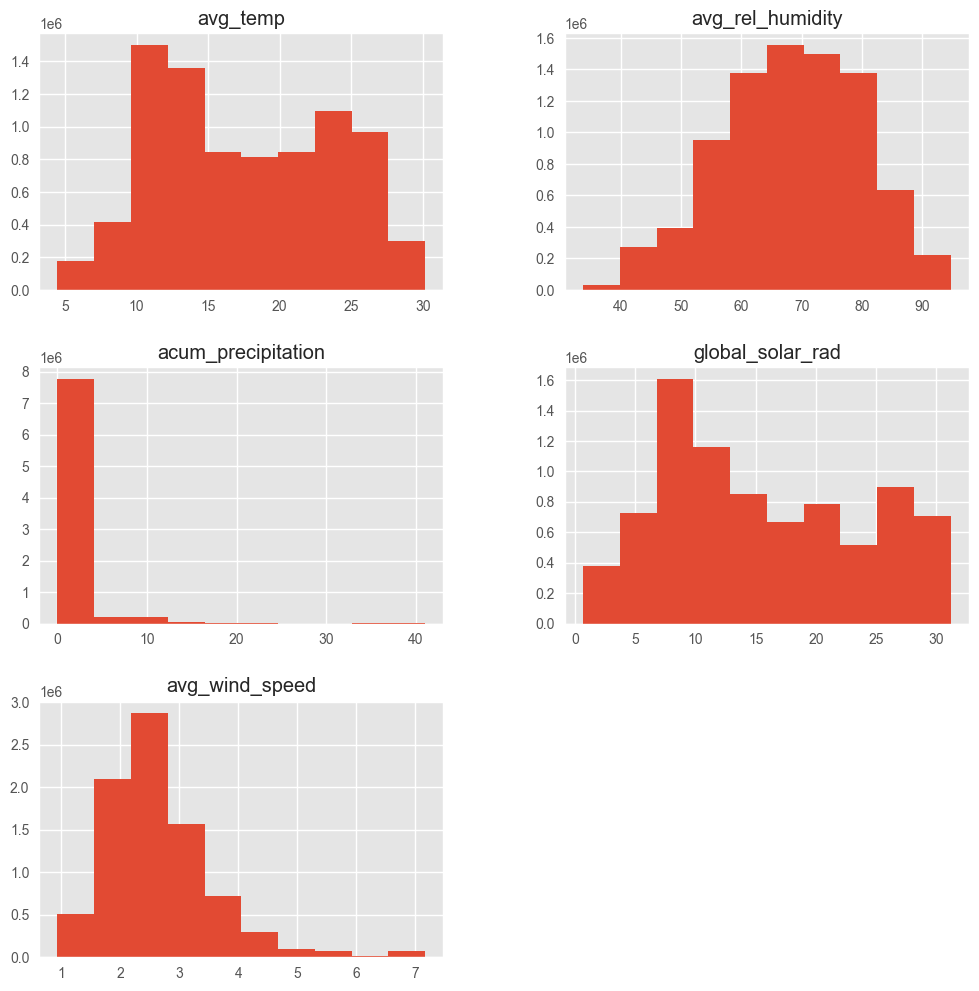

In [62]:
(bicing_X
 .loc[:, meteo_features]
 .hist(figsize=(12, 12))
)

<Axes: ylabel='Frequency'>

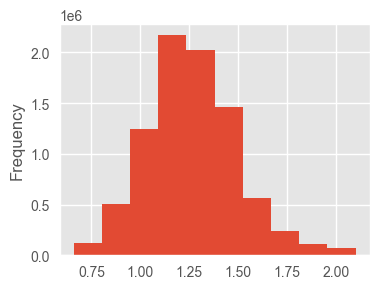

In [92]:
pd.Series(np.log1p(bicing_X['avg_wind_speed'])).plot.hist(figsize=(4, 3))

<Axes: xlabel='percentage_docks_available'>

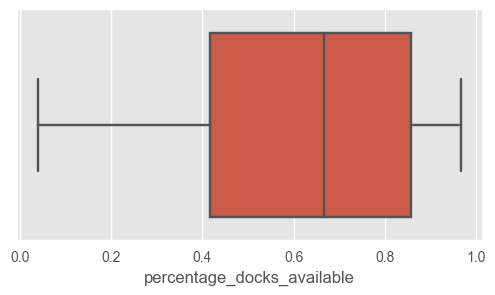

In [63]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(x=bicing_y, ax=ax)

In [26]:
pda_upper, pda_lower = np.percentile(bicing_y, [5, 95])
pda_upper, pda_lower

(0.10000000149011612, 0.9599999785423279)

In [27]:
pda_mean = np.mean(bicing_y)
pda_std = np.std(bicing_y)
pda_mean, pda_std

(0.6166839, 0.2739152)

In [28]:
sigma3_lower, sigma3_upper = pda_mean - 3 * pda_std, pda_mean + 3 * pda_std
sigma3_lower, sigma3_upper

(-0.20506170392036438, 1.4384295046329498)

In [33]:
(bicing_y
 .describe()
)

count    8.498120e+06
mean     6.166839e-01
std      2.739152e-01
min      1.851852e-02
25%      4.090909e-01
50%      6.666667e-01
75%      8.636364e-01
max      9.814815e-01
Name: percentage_docks_available, dtype: float64

In [93]:
bicing_pl.fit_transform(bicing_X, bicing_y)

,station_id,ctx_1,ctx_2,ctx_3,ctx_4,altitude,is_holiday,weekend,avg_temp,avg_rel_humidity,...,season_spring,season_summer,day_sin,day_cos,month_sin,month_cos,hour_sin,hour_cos,weekday_sin,weekday_cos
0,1,0.065217,0.043478,0.043478,0.043478,1.278754,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,0.000000e+00,1.000000,-0.974928,-0.222521
1,1,0.119565,0.065217,0.043478,0.043478,1.278754,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,2.697968e-01,0.962917,-0.974928,-0.222521
2,1,0.108696,0.119565,0.065217,0.043478,1.278754,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,5.195840e-01,0.854419,-0.974928,-0.222521
3,1,0.108696,0.108696,0.119565,0.065217,1.278754,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,7.308360e-01,0.682553,-0.974928,-0.222521
4,1,0.108696,0.108696,0.108696,0.119565,1.278754,True,False,7.650000,67.5,...,0,0,2.012985e-01,0.97953,5.000000e-01,0.866025,8.878852e-01,0.460065,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8498115,519,0.895833,0.916667,0.875000,0.958333,2.053078,False,True,16.299999,59.5,...,0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-8.878852e-01,0.460065,-0.781831,0.623490
8498116,519,0.750000,0.895833,0.916667,0.875000,2.053078,False,True,16.299999,59.5,...,0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-7.308360e-01,0.682553,-0.781831,0.623490
8498117,519,0.666667,0.750000,0.895833,0.916667,2.053078,False,True,16.299999,59.5,...,0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-5.195840e-01,0.854419,-0.781831,0.623490
8498118,519,0.583333,0.666667,0.750000,0.895833,2.053078,False,True,16.299999,59.5,...,0,0,-2.449294e-16,1.00000,-2.449294e-16,1.000000,-2.697968e-01,0.962917,-0.781831,0.623490


In [94]:
X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    bicing_X, bicing_y, test_size=0.2, shuffle=True, random_state=42
)

X_train = bicing_pl.fit_transform(X_raw_train, y_train)
X_test = bicing_pl.transform(X_raw_test)

In [97]:
step_params = {'n_estimators': 150, 'max_depth': 11, 
               'min_child_weight': 3.276003763562555, 
               'max_delta_step': 3.1387766931681127, 
               'scale_pos_weight': 19.413929327351603, 
               'colsample_bytree': 0.9470481938027211, 
               'subsample': 0.9900550802844357, 
               'reg_alpha': 1.74121788874523, 
               'reg_lambda': 8.078566653931562, 
               'gamma': 0.0006815988817603169, 
               'learning_rate': 0.44148979812667377
}

In [98]:
xg = xgb.XGBRegressor(**step_params, tree_method='gpu_hist', enable_categorical=True, early_stopping_rounds=30)
xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg.score(X_test, y_test)

[0]	validation_0-rmse:0.19480	validation_1-rmse:0.19494
[10]	validation_0-rmse:0.11449	validation_1-rmse:0.11659
[20]	validation_0-rmse:0.11222	validation_1-rmse:0.11538
[30]	validation_0-rmse:0.11075	validation_1-rmse:0.11485
[40]	validation_0-rmse:0.10980	validation_1-rmse:0.11467
[50]	validation_0-rmse:0.10891	validation_1-rmse:0.11451
[60]	validation_0-rmse:0.10816	validation_1-rmse:0.11448
[70]	validation_0-rmse:0.10754	validation_1-rmse:0.11444
[80]	validation_0-rmse:0.10692	validation_1-rmse:0.11440
[90]	validation_0-rmse:0.10629	validation_1-rmse:0.11437
[100]	validation_0-rmse:0.10573	validation_1-rmse:0.11438
[110]	validation_0-rmse:0.10520	validation_1-rmse:0.11438
[119]	validation_0-rmse:0.10474	validation_1-rmse:0.11440


0.8255354622173643

In [60]:
xg.best_ntree_limit

100

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series,
                          X_test: pd.DataFrame, y_test: pd.Series, early_stopping_rounds: int=50, metric:callable=mean_squared_error) -> Dict[str, Any]:         
    
    int_vals = ['max_depth', 'reg_alpha']
    space = {k: (int(val) if k in int_vals else val) for k,val in space.items()}
    space['early_stopping_rounds'] = early_stopping_rounds
    model = xgb.XGBRegressor(**space)
    evaluation = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_set=evaluation, verbose=False)
    pred = model.predict(X_test)
    score = metric(y_test, pred)
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

            
params = {'random_state': 42, 'eval_metric': 'rmse'}

rounds = [{'max_depth': hp.quniform('max_depth', 1, 8, 1),  # tree
           'min_child_weight': hp.loguniform('min_child_weight', -2, 3)},
          {'scale_pos_weight':hp.uniform('scale_pos_weight', 0, 10), # imbalanced
           'max_delta_step':hp.uniform('max_delta_step', 0, 10)},
          {'subsample': hp.uniform('subsample', 0.5, 1),   # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)},
          {'reg_alpha': hp.uniform('reg_alpha', 0, 10),
            'reg_lambda': hp.uniform('reg_lambda', 1, 10),},
          {'gamma': hp.loguniform('gamma', -10, 10)}, # regularization
          {'learning_rate': hp.loguniform('learning_rate', -7, 0)} # boosting
]

all_trials = []
for round in rounds:
    params = {**params, **round}
    trials = Trials()
    best = fmin(fn=lambda space: hyperparameter_tuning(space, X_train, 
                                        y_train, X_test, y_test),            
        space=params,           
        algo=tpe.suggest,            
        max_evals=20,            
        trials=trials,
    )
    params = {**params, **best}
    all_trials.append(trials)

In [47]:
xg_round_1 = xgb.XGBRegressor(n_estimators=150, max_depth=10, min_child_weight=3.276003763562555, early_stopping_rounds=30)
xg_round_1.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg_round_1.score(X_test, y_test)

[0]	validation_0-rmse:0.22632	validation_1-rmse:0.22622
[10]	validation_0-rmse:0.12040	validation_1-rmse:0.12084
[20]	validation_0-rmse:0.11861	validation_1-rmse:0.11943
[30]	validation_0-rmse:0.11760	validation_1-rmse:0.11886
[40]	validation_0-rmse:0.11665	validation_1-rmse:0.11832
[50]	validation_0-rmse:0.11571	validation_1-rmse:0.11778
[60]	validation_0-rmse:0.11499	validation_1-rmse:0.11743
[70]	validation_0-rmse:0.11440	validation_1-rmse:0.11717
[80]	validation_0-rmse:0.11383	validation_1-rmse:0.11695
[90]	validation_0-rmse:0.11332	validation_1-rmse:0.11679
[100]	validation_0-rmse:0.11266	validation_1-rmse:0.11647
[110]	validation_0-rmse:0.11223	validation_1-rmse:0.11635
[120]	validation_0-rmse:0.11178	validation_1-rmse:0.11622
[130]	validation_0-rmse:0.11138	validation_1-rmse:0.11613
[140]	validation_0-rmse:0.11093	validation_1-rmse:0.11600
[149]	validation_0-rmse:0.11059	validation_1-rmse:0.11595


0.8207353815330922

In [48]:
xg_round_2 = xgb.XGBRegressor(n_estimators=150, max_depth=10, min_child_weight=3.276003763562555, max_delta_step=3.1387766931681127, 
                      scale_pos_weight=19.413929327351603, early_stopping_rounds=30)
xg_round_2.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg_round_2.score(X_test, y_test)

[0]	validation_0-rmse:0.22632	validation_1-rmse:0.22622
[10]	validation_0-rmse:0.12040	validation_1-rmse:0.12084
[20]	validation_0-rmse:0.11845	validation_1-rmse:0.11931
[30]	validation_0-rmse:0.11740	validation_1-rmse:0.11867
[40]	validation_0-rmse:0.11652	validation_1-rmse:0.11818
[50]	validation_0-rmse:0.11559	validation_1-rmse:0.11765
[60]	validation_0-rmse:0.11497	validation_1-rmse:0.11736
[70]	validation_0-rmse:0.11427	validation_1-rmse:0.11703
[80]	validation_0-rmse:0.11361	validation_1-rmse:0.11676
[90]	validation_0-rmse:0.11304	validation_1-rmse:0.11657
[100]	validation_0-rmse:0.11251	validation_1-rmse:0.11636
[110]	validation_0-rmse:0.11204	validation_1-rmse:0.11622
[120]	validation_0-rmse:0.11165	validation_1-rmse:0.11614
[130]	validation_0-rmse:0.11121	validation_1-rmse:0.11602
[140]	validation_0-rmse:0.11078	validation_1-rmse:0.11595
[149]	validation_0-rmse:0.11041	validation_1-rmse:0.11584


0.8210643289530989

In [49]:
xg_round_3 = xgb.XGBRegressor(n_estimators=150, max_depth=10, min_child_weight=3.276003763562555, max_delta_step=3.1387766931681127, 
                      scale_pos_weight=19.413929327351603, colsample_bytree=0.9470481938027211, subsample=0.9900550802844357, early_stopping_rounds=30)
xg_round_3.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg_round_3.score(X_test, y_test)

[0]	validation_0-rmse:0.22652	validation_1-rmse:0.22641
[10]	validation_0-rmse:0.12041	validation_1-rmse:0.12084
[20]	validation_0-rmse:0.11864	validation_1-rmse:0.11948
[30]	validation_0-rmse:0.11783	validation_1-rmse:0.11905
[40]	validation_0-rmse:0.11673	validation_1-rmse:0.11837
[50]	validation_0-rmse:0.11611	validation_1-rmse:0.11809
[60]	validation_0-rmse:0.11542	validation_1-rmse:0.11773
[70]	validation_0-rmse:0.11466	validation_1-rmse:0.11731
[80]	validation_0-rmse:0.11408	validation_1-rmse:0.11706
[90]	validation_0-rmse:0.11358	validation_1-rmse:0.11688
[100]	validation_0-rmse:0.11309	validation_1-rmse:0.11668
[110]	validation_0-rmse:0.11258	validation_1-rmse:0.11651
[120]	validation_0-rmse:0.11215	validation_1-rmse:0.11640
[130]	validation_0-rmse:0.11172	validation_1-rmse:0.11625
[140]	validation_0-rmse:0.11129	validation_1-rmse:0.11615
[149]	validation_0-rmse:0.11095	validation_1-rmse:0.11607


0.8203554618904081

In [50]:
xg_round_4 = xgb.XGBRegressor(n_estimators=150, max_depth=10, min_child_weight=3.276003763562555, max_delta_step=3.1387766931681127, 
                      scale_pos_weight=19.413929327351603, colsample_bytree=0.9470481938027211, subsample=0.9900550802844357, 
                      reg_alpha=1.74121788874523, reg_lambda=8.078566653931562, early_stopping_rounds=30)
xg_round_4.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg_round_4.score(X_test, y_test)

[0]	validation_0-rmse:0.22661	validation_1-rmse:0.22650
[10]	validation_0-rmse:0.12054	validation_1-rmse:0.12090
[20]	validation_0-rmse:0.11875	validation_1-rmse:0.11942
[30]	validation_0-rmse:0.11782	validation_1-rmse:0.11875
[40]	validation_0-rmse:0.11707	validation_1-rmse:0.11827
[50]	validation_0-rmse:0.11639	validation_1-rmse:0.11784
[60]	validation_0-rmse:0.11587	validation_1-rmse:0.11755
[70]	validation_0-rmse:0.11541	validation_1-rmse:0.11733
[80]	validation_0-rmse:0.11492	validation_1-rmse:0.11705
[90]	validation_0-rmse:0.11440	validation_1-rmse:0.11675
[100]	validation_0-rmse:0.11411	validation_1-rmse:0.11663
[110]	validation_0-rmse:0.11378	validation_1-rmse:0.11649
[120]	validation_0-rmse:0.11345	validation_1-rmse:0.11633
[130]	validation_0-rmse:0.11315	validation_1-rmse:0.11622
[140]	validation_0-rmse:0.11283	validation_1-rmse:0.11611
[149]	validation_0-rmse:0.11248	validation_1-rmse:0.11595


0.8207309910531436

In [53]:
xg_round_5 = xgb.XGBRegressor(n_estimators=150, max_depth=11, min_child_weight=3.276003763562555, max_delta_step=3.1387766931681127, 
                      scale_pos_weight=19.413929327351603, colsample_bytree=0.9470481938027211, subsample=0.9900550802844357, 
                      reg_alpha=1.74121788874523, reg_lambda=8.078566653931562, gamma=0.0006815988817603169, early_stopping_rounds=30)
xg_round_5.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg_round_5.score(X_test, y_test)

[0]	validation_0-rmse:0.22648	validation_1-rmse:0.22640
[10]	validation_0-rmse:0.11964	validation_1-rmse:0.12040
[20]	validation_0-rmse:0.11781	validation_1-rmse:0.11902
[30]	validation_0-rmse:0.11649	validation_1-rmse:0.11816
[40]	validation_0-rmse:0.11548	validation_1-rmse:0.11755
[50]	validation_0-rmse:0.11479	validation_1-rmse:0.11722
[60]	validation_0-rmse:0.11400	validation_1-rmse:0.11679
[70]	validation_0-rmse:0.11339	validation_1-rmse:0.11652
[80]	validation_0-rmse:0.11275	validation_1-rmse:0.11623
[90]	validation_0-rmse:0.11225	validation_1-rmse:0.11607
[100]	validation_0-rmse:0.11171	validation_1-rmse:0.11586
[110]	validation_0-rmse:0.11141	validation_1-rmse:0.11578
[120]	validation_0-rmse:0.11099	validation_1-rmse:0.11569
[130]	validation_0-rmse:0.11068	validation_1-rmse:0.11562
[140]	validation_0-rmse:0.11025	validation_1-rmse:0.11551
[149]	validation_0-rmse:0.10988	validation_1-rmse:0.11537


0.8225101275212225

In [54]:
xg_round_6 = xgb.XGBRegressor(n_estimators=150, max_depth=10, min_child_weight=3.276003763562555, max_delta_step=3.1387766931681127, 
                      scale_pos_weight=19.413929327351603, colsample_bytree=0.9470481938027211, subsample=0.9900550802844357, 
                      reg_alpha=1.74121788874523, reg_lambda=8.078566653931562, gamma=0.0006815988817603169, learning_rate=0.44148979812667377,
                      early_stopping_rounds=30)
xg_round_6.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg_round_6.score(X_test, y_test)

[0]	validation_0-rmse:0.19574	validation_1-rmse:0.19566
[10]	validation_0-rmse:0.11959	validation_1-rmse:0.12006
[20]	validation_0-rmse:0.11803	validation_1-rmse:0.11896
[30]	validation_0-rmse:0.11689	validation_1-rmse:0.11819
[40]	validation_0-rmse:0.11586	validation_1-rmse:0.11754
[50]	validation_0-rmse:0.11504	validation_1-rmse:0.11708
[60]	validation_0-rmse:0.11444	validation_1-rmse:0.11682
[70]	validation_0-rmse:0.11389	validation_1-rmse:0.11655
[80]	validation_0-rmse:0.11337	validation_1-rmse:0.11633
[90]	validation_0-rmse:0.11301	validation_1-rmse:0.11625
[100]	validation_0-rmse:0.11249	validation_1-rmse:0.11607
[110]	validation_0-rmse:0.11210	validation_1-rmse:0.11594
[120]	validation_0-rmse:0.11170	validation_1-rmse:0.11582
[130]	validation_0-rmse:0.11125	validation_1-rmse:0.11568
[140]	validation_0-rmse:0.11101	validation_1-rmse:0.11566
[149]	validation_0-rmse:0.11071	validation_1-rmse:0.11558


0.821879528756605

In [55]:
xg_round_6 = xgb.XGBRegressor(n_estimators=150, max_depth=11, min_child_weight=3.276003763562555, max_delta_step=3.1387766931681127, 
                      scale_pos_weight=19.413929327351603, colsample_bytree=0.9470481938027211, subsample=0.9900550802844357, 
                      reg_alpha=1.74121788874523, reg_lambda=8.078566653931562, gamma=0.0006815988817603169, learning_rate=0.44148979812667377,
                      early_stopping_rounds=30)
xg_round_6.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
xg_round_6.score(X_test, y_test)

[0]	validation_0-rmse:0.19554	validation_1-rmse:0.19550
[10]	validation_0-rmse:0.11853	validation_1-rmse:0.11953
[20]	validation_0-rmse:0.11655	validation_1-rmse:0.11823
[30]	validation_0-rmse:0.11546	validation_1-rmse:0.11767
[40]	validation_0-rmse:0.11468	validation_1-rmse:0.11737
[50]	validation_0-rmse:0.11361	validation_1-rmse:0.11690
[60]	validation_0-rmse:0.11287	validation_1-rmse:0.11664
[70]	validation_0-rmse:0.11219	validation_1-rmse:0.11639
[80]	validation_0-rmse:0.11150	validation_1-rmse:0.11621
[90]	validation_0-rmse:0.11087	validation_1-rmse:0.11601
[100]	validation_0-rmse:0.11037	validation_1-rmse:0.11593
[110]	validation_0-rmse:0.10988	validation_1-rmse:0.11582
[120]	validation_0-rmse:0.10927	validation_1-rmse:0.11569
[130]	validation_0-rmse:0.10868	validation_1-rmse:0.11560
[140]	validation_0-rmse:0.10821	validation_1-rmse:0.11553
[149]	validation_0-rmse:0.10780	validation_1-rmse:0.11545


0.8222763423264449

In [60]:
X_train_full = bicing_pl.fit_transform(bicing_X, bicing_y)
y_train_full = bicing_y

In [65]:
xg_round_6_full = xgb.XGBRegressor(n_estimators=150, max_depth=11, min_child_weight=3.276003763562555, max_delta_step=3.1387766931681127, 
                      scale_pos_weight=19.413929327351603, colsample_bytree=0.9470481938027211, subsample=0.9900550802844357, 
                      reg_alpha=1.74121788874523, reg_lambda=8.078566653931562, gamma=0.0006815988817603169, learning_rate=0.44148979812667377)

xg_round_6_full.fit(X_train_full, y_train_full)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9470481938027211, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0006815988817603169, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.44148979812667377, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=3.1387766931681127, max_depth=11, max_leaves=None,
             min_child_weight=3.276003763562555, missing=nan,
             monotone_constraints=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [66]:
save_object(r'..\models\model_full_20230619_0750.pkl', xg_round_6)

In [59]:
from src.utils import save_object, load_object

# save_object(r'..\models\model_20230619_0720.pkl', xg_round_6)
save_object(r'..\models\pipe_20230619_0720.pkl', bicing_pl)

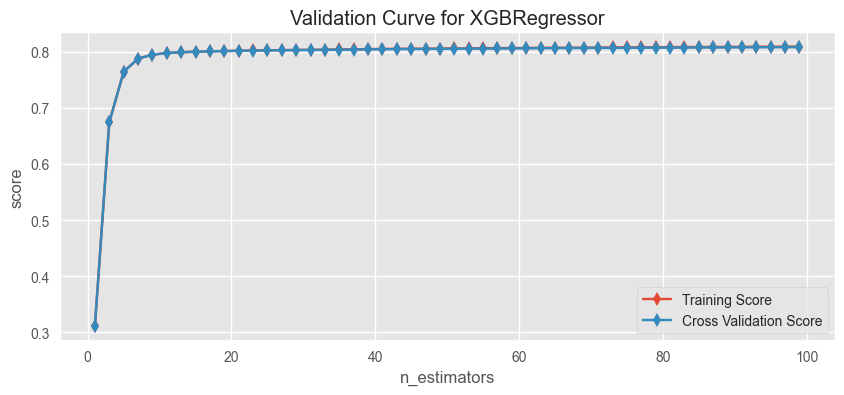

In [37]:
from yellowbrick.model_selection import validation_curve

fig, ax = plt.subplots(figsize=(10, 4))
viz = validation_curve(xgb.XGBRegressor(random_state=42),
                       X=pd.concat([X_train, X_test], axis='index'),
                       y=np.concatenate([y_train, y_test]),
                       param_name='n_estimators', param_range=range(1, 100, 2),
                       scoring='r2', cv=3, 
                       ax=ax)

In [17]:
xg.best_ntree_limit

100

In [18]:
xg.feature_importances_

array([5.3074341e-03, 9.2970932e-01, 1.6331745e-02, 2.4543803e-03,
       3.6298698e-03, 5.6999433e-03, 1.0728481e-03, 5.4674614e-03,
       1.5431895e-03, 6.8195112e-04, 8.9754240e-04, 1.7887242e-03,
       6.4209732e-04, 1.2744451e-03, 5.0275255e-04, 4.0623937e-03,
       5.6942314e-04, 6.8756967e-04, 1.8565538e-03, 2.3406893e-03,
       5.5348175e-03, 5.3159366e-03, 1.2049015e-03, 1.4239945e-03],
      dtype=float32)

<Axes: >

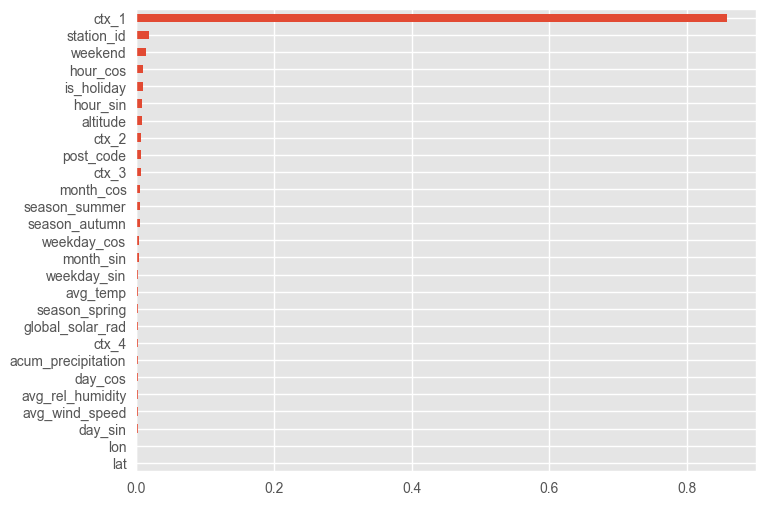

In [114]:
fig, ax = plt.subplots(figsize=(8, 6))
(pd.Series(xg.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)

In [20]:
results = xg.evals_result()
JSON(results)

<IPython.core.display.JSON object>

Text(0, 0.5, 'rsme')

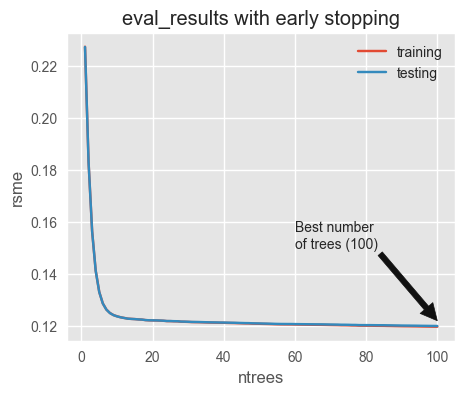

In [21]:
ax = (pd.DataFrame({'training': results['validation_0']['rmse'],
                   'testing': results['validation_1']['rmse']})
      .assign(ntrees=lambda tree: range(1, len(tree)+1))
      .set_index('ntrees')
      .plot(figsize=(5, 4), title='eval_results with early stopping')
      
      )
ax.annotate('Best number \nof trees (100)', xy=(100, 0.122),
            xytext=(60, 0.15), arrowprops={'color': 'k'})
ax.set_ylabel('rsme')

In [22]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
dtr.score(X_test, y_test)

0.5948245029214614

<Axes: >

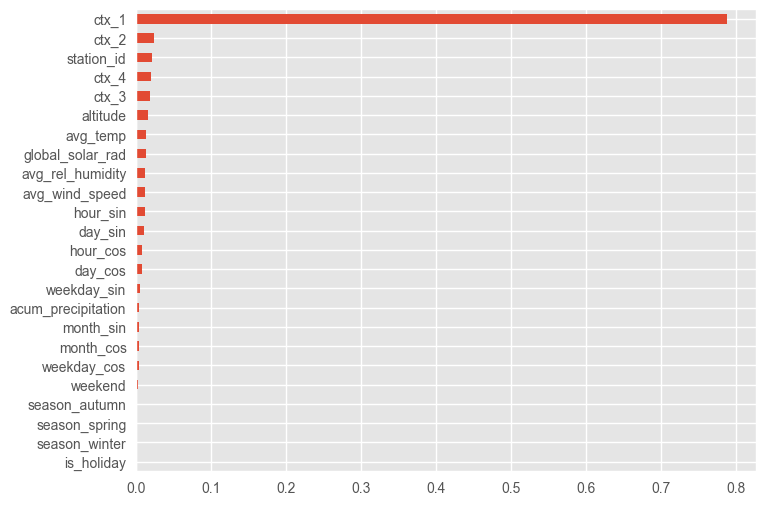

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
(pd.Series(dtr.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)

In [24]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=10)
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.7851787957309094

<Axes: >

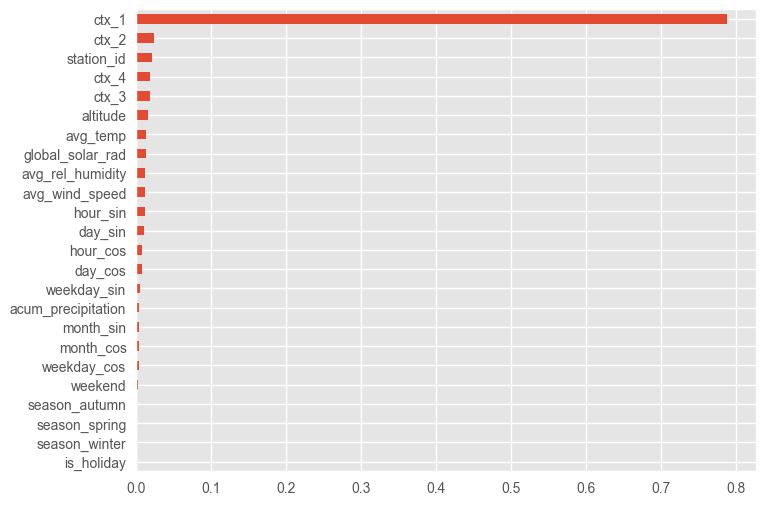

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
(pd.Series(rfr.feature_importances_, index=X_train.columns)
 .sort_values()
 .plot.barh(ax=ax)
)

In [ ]:
def get_rawX_y(df, y_col, drop_set):
    raw = (df
           .set_index('year')
           .drop(index=drop_set)
           .reset_index()
          )
    return raw.drop(columns=['year', y_col]), raw[y_col]

drop_sets = [[2019, 2020], 2019, 2020, []]

for drop_set in drop_sets:
    
    bicing_X, bicing_y = get_rawX_y(bicing, 'percentage_docks_available', drop_set)

    X_raw_train, X_raw_test, y_train, y_test = train_test_split(
        bicing_X, bicing_y, shuffle=True, random_state=42
    )

    X_train = bicing_pl.fit_transform(X_raw_train, y_train)
    X_test = bicing_pl.transform(X_raw_test)
    
    print(f'- Drop set: {drop_set}')
    print('-' * 80)
    
    
    xg = xgb.XGBRegressor(early_stopping_rounds=35)
    xg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=10)
    xg.score(X_test, y_test)
    
    print('\n')
    print(f'Best rsme score: {xg.best_score}')
    print('=' * 80)

In [31]:
xg.best_ntree_limit

500

In [1]:
import joblib

In [28]:
# best_model = load_object(r'..\models\model.pkl')
# best_model.best_score